## ecom.tech ноутбук к соревнованию по NLP-задачи мульти-лейбл классификации отзывов о доставке. Часть 1 - Дообучение модели и получение весов

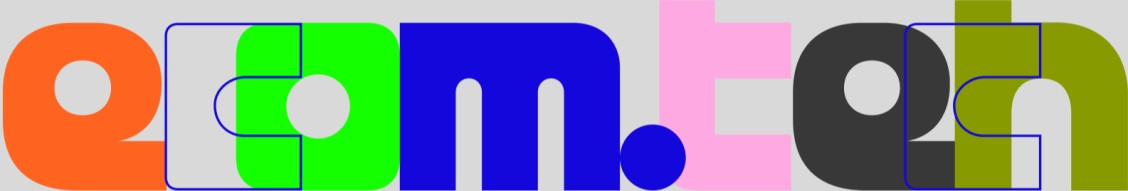

**Важно!**

Обязательно изменить пути к тренировочным данным и файлу с описанием классов - пункт ноутбука `Обработка данных`. Далее обязательно изменить путь сохранения весов модели, особенно критически это касается `best`-версии - именно она будет использоваться для составления прогнозов.

Не стоит сразу же нажимать на `Выполнить всё`. Советую выполнять ячейки поэтапно, попутно читая всю информацию. Спасибо.

# Импорт библиотек

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import warnings
import os
import random

from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_name = 'ai-forever/ruRoberta-large'

Следующий код запускает подключение Google Drive. Я работал в Colab, поэтому просьба закомментировать строчку, если он не потребуется.

In [ ]:
# подключение Google Drive, где лежат данные
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def set_seed(seed):
    '''Зафиксируем случайности'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_STATE)

Random seed set as 42


# Подготовка данных

**Памятка**: просьба сменить пути к файлам описания классов (`trends_description.csv`) и файл с тренировочными данными (`train.csv`), иначе случится ошибка.

In [ ]:
descrs = pd.read_csv('/content/drive/MyDrive/ecom-tech/trends_description.csv')

In [ ]:
train_df = pd.read_csv(
    '/content/drive/MyDrive/ecom-tech/train.csv'
    ).drop(['assessment', 'Unnamed: 0', 'index', 'tags'], axis=1)

In [ ]:
train_df[[f'trend_id_res{i}' for i in range(50)]] = train_df[[f'trend_id_res{i}' for i in range(50)]].astype(bool)
train_df['text'] = train_df['text'].astype(str)

In [ ]:
train_df.head()

,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,"Маленький выбор товаров, хотелось бы ассортиме...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Быстро,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Доставка постоянно задерживается,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Наценка и ассортимент расстраивают,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Можно немного скинуть минимальную сумму заказа...,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Разделим наши данные на обучающую и тестовую части.

In [ ]:
train_data, val_data = train_test_split(
    train_df,
    random_state=RANDOM_STATE,
    test_size=0.2
    )

# ruRoBERTa - дообучение

Эксприментальным путём мы выявили модель, показывающую себя на пока что лучше остальных - это `ai-forever/ruRoberta-large`. Объявим токенизатор и создаим эмбеддинги из наших текстов.

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification


tokenizer = RobertaTokenizer.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.text = list(df['text'])
        self.max_len = max_len
        self.targets = self.df[target_list].values

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'text': text,
            'targets': torch.FloatTensor(self.targets[index])
        }

        return item

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 32
targets = [f'trend_id_res{i}' for i in range(50)]

train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN, targets)
val_dataset = CustomDataset(val_data, tokenizer, MAX_LEN, targets)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)


val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

Взгляним, как выглядят наши данные из датасета.

In [ ]:
next(iter(train_dataset))

{'input_ids': tensor([    1,  5560,    16,   451,  3362,    50, 25602,    65,   283,    18,
           289,  3362,    50, 25602,    65,  1003,    18,   664,  2007,  1528,
           332,  3634,  4777,  4789,  1011, 36142,    16,  3009,  7219,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

Объявим наш класс для BERT и объявим выбранную модель.

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        self.bert_model = RobertaForSequenceClassification.from_pretrained(
            model_name,
            return_dict=True,
            problem_type='multi_label_classification',
            num_labels=50
        )

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )

        return output.logits

model = BERTClass().to(device)

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Зададим функцию потерь - Бинарную кросс-энтропию и оптимизатор - Адам. В ходе наблюдений выявлен оптимальный размер градиентного шага - 1e-5.

In [ ]:
def loss_fn(outputs, targets):
    '''Бинарная кросс-энтропия'''
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
from transformers import AdamW

# экспериментальным путём определено оптимальное число эпох
EPOCHS = 50
optimizer = AdamW(model.parameters(), lr = 1e-5)

Далее с помощью двух функций в ходе 50 эпох дообучим и составим валидацию модели.

In [ ]:
def ecom_format(y):
    '''Перевод y в формат соревнования ecom.tech'''
    y = [' '.join(np.where(y[i] == 1)[0].astype(str).tolist()) for i in range(y.shape[0])]
    return np.array(y)

def train_model(training_loader, model, optimizer):
    '''Дообучение модели'''
    losses = []
    correct_predictions = 0
    num_samples = 0

    model.train()

    loop = tq.tqdm(
        enumerate(training_loader),
        total=len(training_loader),
        leave=True,
        colour='steelblue'
    )

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs = (outputs >= 0.45).astype(float)

        targets = targets.cpu().detach().numpy()

        outputs = ecom_format(outputs)
        targets = ecom_format(targets)

        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
def eval_model(validation_loader, model, optimizer):
    '''Валидация модели'''
    losses = []
    correct_predictions = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():

        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            outputs = torch.sigmoid(outputs).cpu().detach().numpy()
            outputs = (outputs >= 0.45).astype(float)
            targets = targets.cpu().detach().numpy()

            outputs = ecom_format(outputs)
            targets = ecom_format(targets)
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size

    return float(correct_predictions)/num_samples, np.mean(losses)

Для лучшей наглядности обучения и контроля за временем импортируем библиотеку tqdm. Следующий код запускает дообучение модели.

**Важно:** нужно задать имя для сохранения весов модели. Их потом стоит использовать в ходе составления прогнозов.

In [ ]:
from collections import defaultdict
import tqdm.notebook as tq


history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss = train_model(
        train_data_loader,
        model,
        optimizer
        )

    val_acc, val_loss = eval_model(
        val_data_loader,
        model,
        optimizer
        )

    print(f'train_loss={train_loss:.4f}, \
            val_loss={val_loss:.4f}, \
            train_acc={train_acc:.4f}, \
            val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "/content/drive/MyDrive/ecom-tech/ruroberta-ecom-tech-best.pth")
        best_accuracy = val_acc

Epoch 1/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.2798,             val_loss=0.1524,             train_acc=0.0008,             val_acc=0.0000
Epoch 2/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1413,             val_loss=0.1191,             train_acc=0.0000,             val_acc=0.0000
Epoch 3/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1179,             val_loss=0.1019,             train_acc=0.0016,             val_acc=0.0130
Epoch 4/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1018,             val_loss=0.0878,             train_acc=0.0665,             val_acc=0.2227
Epoch 5/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0898,             val_loss=0.0789,             train_acc=0.1944,             val_acc=0.2984
Epoch 6/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0800,             val_loss=0.0702,             train_acc=0.2785,             val_acc=0.3773
Epoch 7/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0712,             val_loss=0.0642,             train_acc=0.3678,             val_acc=0.4238
Epoch 8/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0639,             val_loss=0.0600,             train_acc=0.4329,             val_acc=0.4584
Epoch 9/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0582,             val_loss=0.0574,             train_acc=0.4905,             val_acc=0.4789
Epoch 10/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0526,             val_loss=0.0551,             train_acc=0.5381,             val_acc=0.4886
Epoch 11/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0479,             val_loss=0.0530,             train_acc=0.5738,             val_acc=0.4941
Epoch 12/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0436,             val_loss=0.0514,             train_acc=0.6190,             val_acc=0.5189
Epoch 13/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0400,             val_loss=0.0498,             train_acc=0.6558,             val_acc=0.5351
Epoch 14/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0369,             val_loss=0.0496,             train_acc=0.6741,             val_acc=0.5341
Epoch 15/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0339,             val_loss=0.0478,             train_acc=0.7028,             val_acc=0.5546
Epoch 16/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0312,             val_loss=0.0480,             train_acc=0.7207,             val_acc=0.5405
Epoch 17/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0286,             val_loss=0.0455,             train_acc=0.7512,             val_acc=0.5481
Epoch 18/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0263,             val_loss=0.0465,             train_acc=0.7774,             val_acc=0.5449
Epoch 19/50


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0243,             val_loss=0.0450,             train_acc=0.7996,             val_acc=0.5600
Epoch 20/50


  0%|          | 0/116 [00:00<?, ?it/s]

# Валидация модели

Ещё раз проведём валидацию модели и посмотрим, где модель больше всего ошибается, на каких классах.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_predictions(model, data_loader):
    '''Получение предсказаний на валидационных данных'''
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        text = data["text"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).detach().cpu()

        preds = outputs.round()
        targets = targets.detach().cpu()

        texts.extend(text)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return texts, predictions, prediction_probs, target_values

In [ ]:
texts, predictions, prediction_probs, target_values = get_predictions(model, val_data_loader)

In [ ]:
print(classification_report(target_values, predictions, target_names=targets))

# График ecom.tech accuracy

Посмотрим, как на тренировочных и валидационных данных менялся размер метрики, составленной в ходе соревнования.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);
plt.grid()
plt.show()

# Сохранение последней модели

На всякий случай сохраним последнюю модель.
**Важно:** нужно задать имя для сохранения весов модели. Если нет желания сохранять последнюю модель, то просьба прокомментировать этот код решёткой.

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/ecom-tech/ruroberta-ecom-tech-last.pth")

# Итого

Чтобы не загружать один ноутбук и дообучением, и прогнозами, было принято решение разделить ноутбук на две части. Ноутбук `Samoilov Vadim ecom.tech NLP Prediction` использовавлся для выполнения предсказаний, которые затем заливались на воркшоп. Просьба пройти в данный ноутбук и быть готовым загрузить туда полученную модель - по дефолту она имеет название `ruroberta-ecom-tech-best.pth`.

Благодарю за уделённое время моей работе! Увидимся во второй части - `Samoilov Vadim ecom.tech NLP Prediction`!
